## Autoencoder

Denoising Autoencoder with deep convolutional layers

### train and eval

In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import MyMNIST, NoisyMNIST
from models.autoencoder import Autoencoder

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
BATCH_SIZE = 1024
LR = 3e-1
MOMENTUM = 0.1
NUM_EPOCH = 10

mnist_train = NoisyMNIST(root = "./data/", train = True, download = True)
mnist_test = NoisyMNIST(root = "./data/", train = False, download = True)

mnist_train = DataLoader(mnist_train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)
mnist_test = DataLoader(mnist_test, batch_size = BATCH_SIZE, shuffle = False, num_workers = 8)

model = Autoencoder()
model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)

losses = {"train": [], "val": []}
batches_train = len(mnist_train)
batches_test = len(mnist_test)
for epoch in range(1, NUM_EPOCH + 1):
    progbar = tqdm(range(batches_train), total=batches_train)
    progbar.set_description(f"Epoch [{epoch} / {NUM_EPOCH}]")

    # Training
    model.train()
    training_loss = 0
    for data, target, _ in mnist_train:
        optimizer.zero_grad()
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        outputs = model(data)
        loss = model.loss_function(outputs, target, loss_type = "binary")['loss']
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        progbar.update()
    
    training_loss /= batches_train
    losses["train"].append(round(training_loss, 4))

    # Validation
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, target, _ in mnist_test:
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            outputs = model(data)
            loss = model.loss_function(outputs, target, loss_type = "binary")['loss']
            validation_loss += loss.item()

    validation_loss /= batches_test
    losses["val"].append(round(validation_loss, 4))
    progbar.set_postfix(val_loss=f"{validation_loss:.4f}")

Epoch [9 / 10]: 100%|██████████| 59/59 [00:04<00:00, 12.32it/s, val_loss=0.1431]


### Visualization

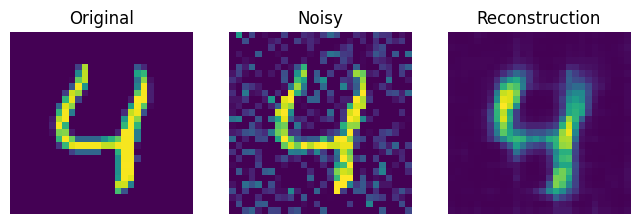

In [2]:
import matplotlib.pyplot as plt

x_hat = mnist_test.dataset[4][0]
x = mnist_test.dataset[4][1]
y = model(x.unsqueeze(0).to(DEVICE)).squeeze(0).cpu().detach()

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
axs = axs.flat
titles = ["Original", "Noisy", "Reconstruction"]
imgs = [x, x_hat, y]

for ax, title, img in zip(axs, titles, imgs):

    ax.imshow(img.squeeze(0))
    ax.set_title(f'{title}')
    ax.axis('off')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.548515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.589920


[t-SNE] KL divergence after 1000 iterations: 1.751758


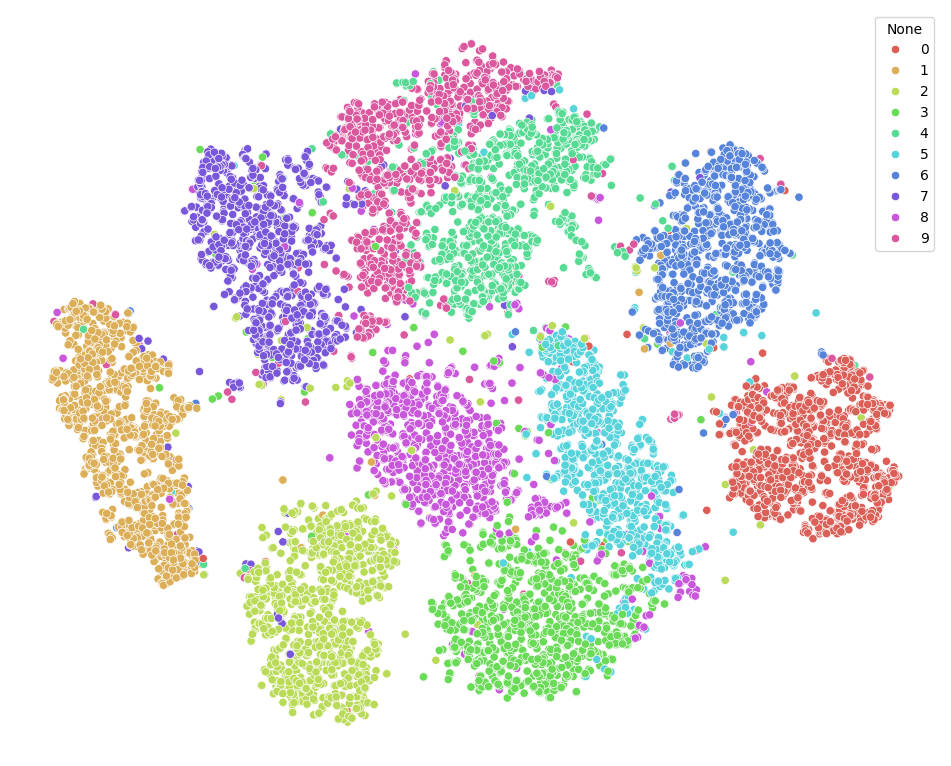

In [3]:
import seaborn as sns
from sklearn.manifold import TSNE

test_dataset = mnist_test.dataset
with torch.no_grad():
    model.cpu()
    
    encoded = torch.flatten(model.encoder(test_dataset.data.cpu()), 1)
    embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedded[:, 0], y=embedded[:, 1],
        hue = test_dataset.labels.cpu(),
        palette = sns.color_palette("hls", 10),
        legend = "full",
    )
    plt.tight_layout()
    plt.axis('off')

## Variational Autoencoder

Simple implementation of $\beta$-VAE

In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import MyMNIST, NoisyMNIST
from models.autoencoder import Autoencoder

## Test